In [2]:
#%%
#Import dependencies
from scipy.ndimage import rotate
import numpy as np
#%matplotlib notebook
import nibabel as nib
import matplotlib as mlp
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import pandas as pd # for csv.
from matplotlib import cm
from matplotlib.lines import Line2D
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from os.path import exists,split,join,splitext
from os import makedirs
import glob
import requests
from collections import defaultdict
#import nrrd
import torch
from torch.nn.functional import grid_sample
import tornado
import copy
import skimage
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pandas as pd
## OPTION B: skip cell if installed STalign with pip or pipenv
import sys
sys.path.append("../../STalign") 
import STalign
import SimpleITK as sitk
## import STalign from upper directory


In [3]:
list_visium=["A1","B1","C1","D1"]
diferent_visum_slicies=["L1","L2","L3","L4"]
list_slice=[220,230,240,250,215,225,235,245]
talls=["26","28"]
mult=[1,4.96]
itkimage = sitk.ReadImage("../atlasVolume/atlasVolume.mhd")
ct_scan = sitk.GetArrayFromImage(itkimage)
Y_total=pd.read_excel("Y_SC26_A1.xlsx")
Y_total.set_index(["pxl_row_transformed","pxl_column_transformed"], inplace=True)
A = ct_scan.transpose(2,1,0) 
cellprob=pd.read_csv("class_prediction_table_v1.txt",header=0,sep=",")
if torch.cuda.is_available():
    torch.set_default_device('cuda:0')
else:
    torch.set_default_device('cpu')
sigmaA = 0.18 #standard deviation of artifact intensities
sigmaB = 0.18 #standard deviation of background intensities
sigmaM = 0.18#standard deviation of matching tissue intenities

In [3]:
%%time
Y_total=pd.read_excel("Y_SC26_A1.xlsx")
Y_total.set_index(["pxl_row_transformed","pxl_column_transformed"], inplace=True)
pd.options.mode.chained_assignment = None  # default='warn'
for tall in range(len(talls)):
    for t in range(len(list_visium)):
        for reverse in range(2):
            image_file = '../visium_data/sccanals'+talls[tall]+'/'+ list_visium[t] +'_mod.jpg'
            V = plt.imread(image_file)
            Vnorm = STalign.normalize(V)
            I = Vnorm.transpose(2,0,1)
            if(t+tall*4) == 6: 
                I = I[0:200,1500:4200,1000:3400]
                dif = 2400
            else:
                I = I[0:200,1500:4200,400:3000]
                dif = 2600
            if reverse == 1:
                I = np.flip(I,axis=2)
            YI = np.array(range(I.shape[1]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
            XI = np.array(range(I.shape[2]))*1. # needs to be longs not doubles for STalign.transform later so multiply by 1.
            X_ = np.arange(0, 1000, 1)
            Y_ = np.arange(0, 1000, 1)
            xI = [Y_,X_]       
            slice = list_slice[t+tall*4]    
            extentI = STalign.extent_from_x((YI,XI))
            pointsIlist = np.load('../visium_data/sccanals'+talls[tall]+'/model_'+ list_visium[t] + "_" + str(reverse) +'_points.npy', allow_pickle=True).tolist()
            pointsJlist = np.load('../visium_data/sccanals'+talls[tall]+'/visum_'+ list_visium[t] + "_" + str(reverse) +'_points.npy', allow_pickle=True).tolist()
            pointsI = []
            pointsJ = []    
            YI = (np.array(range(I.shape[1]))*1.).astype(np.float64) # needs to be longs not doubles for STalign.transform later so multiply by 1.
            XI = (np.array(range(I.shape[2]))*1.).astype(np.float64) # needs to be longs not doubles for STalign.transform later so multiply by 1.
            for i in pointsIlist.keys():
                for j in range(len(pointsIlist[i])):
                    pointsI.append([pointsIlist[i][j][1], pointsIlist[i][j][0]])
                    
            for i in pointsJlist.keys():
                for j in range(len(pointsJlist[i])):
                    pointsJ.append([pointsJlist[i][j][1], pointsJlist[i][j][0]])    
            pointsI = np.array(pointsI)
            pointsJ = np.array(pointsJ)
            I = STalign.normalize((I).astype(np.float64))
            L,T = STalign.L_T_from_points(pointsI,pointsJ)
            extentI = STalign.extent_from_x((YI,XI))
            J = (A[slice][None] / np.mean(np.abs(A[slice]),keepdims=True)).astype(np.float64)
            J = J[:,:280,:]
            j_norm = STalign.normalize(-J)
            j_norm = np.vstack((j_norm,j_norm,j_norm))
            XJ = (np.array(range(J.shape[2]))*1.).astype(np.float64)
            YJ = (np.array(range(J.shape[1]))*1.).astype(np.float64)
            extentJ = STalign.extent_from_x((YJ,XJ))
            xJ = [YJ,XJ]
            xI = [YI,XI]
            xJ = [YJ,XJ]
            torch.cuda.empty_cache()
            transform = STalign.LDDMM(xI,I,xJ,j_norm,L=L,T=T,pointsI= pointsI,pointsJ=pointsJ,nt=9,niter=500,diffeo_start = 16,device='cuda:0',a=110,p=3,sigmaP = 2e-1,epL= 8e-11,epT= 5e-3,epV= 5e-2,
            sigmaA = sigmaA,sigmaB = sigmaB,sigmaM = sigmaM,display=False,)
            A_transformed = transform['A']
            v = transform['v']
            xv = transform['xv']
            WM = transform['WM'].tolist()
            WB = transform['WB'].tolist()
            WA = transform['WA'].tolist()
            fname = '../visium_data/sccanals'+talls[tall]+'/'+ list_visium[t] +'_tissue_positions.csv'
            df1 = pd.read_csv(fname)
            df1["pxl_row_in_fullres"]=(df1["pxl_row_in_fullres"]/mult[tall]).astype(int)
            df1["pxl_col_in_fullres"]=(df1["pxl_col_in_fullres"]/mult[tall]).astype(int)
            df1=df1[df1["in_tissue"]==1]
            if(t+tall*4)==6: 
                df1=df1[df1["pxl_col_in_fullres"]>1000]
                df1=df1[df1["pxl_col_in_fullres"]<3400]
                df1=df1[df1["pxl_row_in_fullres"]>1500]
                df1=df1[df1["pxl_row_in_fullres"]<4200]
                if reverse == 0:
                    xI = (np.array(df1['pxl_col_in_fullres']-1000)).astype(np.float64)
                else: 
                    xI = (np.array(+1000-(df1["pxl_col_in_fullres"]-dif))).astype(np.float64)
                yI = (np.array(df1['pxl_row_in_fullres']-1500)).astype(np.float64)
            else:   
                df1=df1[df1["pxl_col_in_fullres"]>400]
                df1=df1[df1["pxl_col_in_fullres"]<3000]
                df1=df1[df1["pxl_row_in_fullres"]>1500]
                df1=df1[df1["pxl_row_in_fullres"]<4200]
                if reverse == 0:
                    xI = (np.array(df1['pxl_col_in_fullres']-400)).astype(np.float64)
                else:
                    xI = (np.array(+400-(df1["pxl_col_in_fullres"]-dif))).astype(np.float64)
                yI = (np.array(df1['pxl_row_in_fullres']-1500)).astype(np.float64)
            tpointsI= STalign.transform_points_source_to_target(xv,v,A_transformed, np.stack([yI, xI], 1))
            if tpointsI.is_cuda:
                tpointsI = tpointsI.cpu()
            xI_LDDMM = tpointsI[:,1]
            yI_LDDMM = tpointsI[:,0]
            df1["pxl_row_transformed"]=yI_LDDMM.numpy().astype(int).tolist()
            df1["pxl_column_transformed"]=xI_LDDMM.numpy().astype(int).tolist()
            cellprob_used=cellprob[(cellprob["project"]=="SCCANALS"+talls[tall]) &(cellprob["genotype"]=="WT")&(cellprob["litter"]=="SCC"+talls[tall]+"_"+diferent_visum_slicies[t]) ]
            cellprob_used["cell_barcode"]=cellprob_used["cell_barcode"].apply(lambda x: x.split("_")[0])
            Y_to_pred=pd.merge(df1,cellprob_used, left_on="barcode",right_on="cell_barcode")
            estri = sitk.ReadImage("../atlasVolume/estriat-Segment_15861-label.mhd")
            est = sitk.GetArrayFromImage(estri)
            estriat = est.transpose(2,1,0) 
            es = (estriat[slice][None] / np.mean(np.abs(estriat[slice]),keepdims=True)).astype(np.float64)
            es=es[:,:280,:]
            es[es<1.]=None
            es = pd.DataFrame(es[0]).stack().rename_axis(['pxl_row_transformed', 'pxl_column_transformed']).reset_index(name="is_estriatum")
            es.set_index(['pxl_row_transformed', 'pxl_column_transformed'], inplace=True)
            Y_to_pred.set_index(["pxl_row_transformed","pxl_column_transformed"], inplace=True)
            Y_to_pred=Y_to_pred.join(es, how='inner')
            Y_to_pred["slice"]=slice
            Y_to_pred["exper"]="S"+talls[tall]
            Y_total=pd.concat([Y_total,Y_to_pred])

C:\Users\Albert\AppData\Roaming\Python\Python312\site-packages\torch\functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
<timed exec>:110: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


CPU times: total: 3min 25s
Wall time: 5min 51s


In [236]:
litters=Y_total["litter"].drop_duplicates().to_list()
Y_total=Y_total.set_index("litter",append=True)

KeyError: 'litter'

In [7]:
%%time
from os import listdir
from os.path import isfile, join,isdir
import random
itkimage = sitk.ReadImage("../atlasVolume/atlasVolume.mhd")
mypath="./gen-download/gen_list"
onlyfiles = [f for f in listdir(mypath) if isdir(join(mypath, f))]
onlyfiles=random.sample(onlyfiles,10)
X_for_pred=Y_total[["pxl_row_in_fullres","pxl_col_in_fullres"]]

X_for_pred=pd.DataFrame()
for i in range(len(onlyfiles)):
    x_partial=pd.DataFrame()
    #if onlyfiles[i] not in X_for_pred:
     #           X_for_pred.loc[:,onlyfiles[i]] = 0.
    files=listdir(mypath+"/"+onlyfiles[i])
    files=[j for j in files if ".mhd" in j ]        
    gen = sitk.ReadImage(mypath+"/"+onlyfiles[i]+"/"+files[0])
    gen = sitk.Resample(gen,itkimage)
    gen = sitk.GetArrayFromImage(gen)        
    gen = gen.transpose(2,1,0)
    for j in range(len(litters)):
        gen_slice = (gen[list_slice[j]][None] / np.mean(np.abs(gen[list_slice[j]]),keepdims=True)).astype(np.float64)  
        gen_slice=gen_slice[:,:280,:]
        gen_slice[gen_slice<0.]=0.
    
        df = pd.DataFrame(gen_slice[0]).stack().rename_axis(['pxl_row_transformed', 'pxl_column_transformed']).reset_index(name=onlyfiles[i])
        df["litter"]=litters[j]
        es = (estriat[list_slice[j]][None] / np.mean(np.abs(estriat[list_slice[j]]),keepdims=True)).astype(np.float64)
        es = es[:,:280,:]
        es[es<1.]=None
        es = pd.DataFrame(es[0]).stack().rename_axis(['pxl_row_transformed', 'pxl_column_transformed']).reset_index(name="is_estriatum")
        es.set_index(['pxl_row_transformed', 'pxl_column_transformed'], inplace=True)
        df.set_index(['pxl_row_transformed', 'pxl_column_transformed'], inplace=True)
        df=df.join(es, how='inner')
        df=df.set_index("litter",append=True)
        df=df.drop("is_estriatum", axis='columns')
        if not x_partial.empty:
            x_partial=pd.concat([x_partial,df])
        else:
            x_partial=df
    if not X_for_pred.empty:
        X_for_pred=X_for_pred.join(x_partial, how='left')
    else:
        X_for_pred=x_partial

NameError: name 'litters' is not defined

array([185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197,
       198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210,
       211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223,
       224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236,
       237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249,
       250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262,
       263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275,
       276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288,
       289, 290, 291, 292, 294], dtype=int64)

In [113]:
X_for_pred

Gria1      Nde1  \
pxl_row_transformed pxl_column_transformed slice                       
167                 140                    185    3.285278  2.150037   
170                 140                    185    3.775901  1.802061   
171                 140                    185    3.986917  1.697653   
172                 140                    185    4.197932  1.593245   
                    141                    185    4.131750  1.723137   
...                                                    ...       ...   
128                 106                    291    0.000000  4.486613   
129                 106                    291    0.000000  3.992234   
128                 106                    292    0.000000  4.786445   
131                 107                    292    0.000000  4.547422   
130                 106                    294    0.000000  4.243884   

                                                     Rps12      Nfe2  \
pxl_row_transformed pxl_column_transformed slice                       
167                 140                    185    2.225775  0.018917   
170                 140                    185    1.875011  0.022418   
171                 140                    185    1.689269  0.023657   
172                 140                    185    1.503528  0.024897   
                    141                    185    1.530051  0.019367   
...                                                    ...       ...   
128                 106                    291    0.000000  0.000000   
129                 106                    291    0.000000  0.000000   
128                 106                    292    0.000000  0.000000   
131                 107                    292    0.000000  0.000000   
130                 106                    294    0.000000  0.000000   

                                                      Cux2     Foxq1  \
pxl_row_transformed pxl_column_transformed slice                       
167                 140                    185    7.343300  2.049448   
170                 140                    185    7.879128  1.974508   
171                 140                    185    7.888062  1.962778   
172                 140                    185    7.896996  1.951048   
                    141                    185    6.854491  1.956722   
...                                                    ...       ...   
128                 106                    291    0.358248  1.128465   
129                 106                    291    0.462111  1.125606   
128                 106                    292    0.317090  1.590478   
131                 107                    292    1.208568  2.264164   
130                 106                    294    0.401659  2.394258   

                                                     Hmgn5     Cdh13  \
pxl_row_transformed pxl_column_transformed slice                       
167                 140                    185    0.009481  2.814636   
170                 140                    185    0.009856  3.365447   
171                 140                    185    0.009550  3.592534   
172                 140                    185    0.009245  3.819621   
                    141                    185    0.007451  3.383571   
...                                                    ...       ...   
128                 106                    291    0.000000  0.000000   
129                 106                    291    0.000000  0.000000   
128                 106                    292    0.000000  0.000000   
131                 107                    292    0.000000  0.000000   
130                 106                    294    0.000000  0.000000   

                                                     Smad9     Grid2  
pxl_row_transformed pxl_column_transformed slice                      
167                 140                    185    0.046623  0.006387  
170                 140                    185    0.061877  0.009015  
171                 1

In [92]:
%%time
capas = dfes[dfes["value"]!=0]["x"].unique()
from os import listdir
from os.path import isfile, join,isdir
import random
estri = sitk.ReadImage("../atlasVolume/estriat-Segment_15861-label.mhd")
est = sitk.GetArrayFromImage(estri)
estriat = est.transpose(2,1,0) 
itkimage = sitk.ReadImage("../atlasVolume/atlasVolume.mhd")
mypath = "./gen-download/gen_list"
onlyfiles = [f for f in listdir(mypath) if isdir(join(mypath, f))]
#onlyfiles = random.sample(onlyfiles,10)

X_for_pred = pd.DataFrame()

for i in range(len(onlyfiles)):
    x_partial = pd.DataFrame()
    #if onlyfiles[i] not in X_for_pred:
     #           X_for_pred.loc[:,onlyfiles[i]] = 0.
    files = listdir(mypath+"/"+onlyfiles[i])
    files = [j for j in files if ".mhd" in j ]        
    gen = sitk.ReadImage(mypath+"/"+onlyfiles[i]+"/"+files[0])
    gen = sitk.Resample(gen,itkimage)
    gen = sitk.GetArrayFromImage(gen)        
    gen = gen.transpose(2,1,0)
    for j in capas:
        gen_slice = (gen[j][None] / np.mean(np.abs(gen[j]),keepdims=True)).astype(np.float64)  
        gen_slice = gen_slice[:,:280,:]
        gen_slice[gen_slice<0.]=0.        
        df = pd.DataFrame(gen_slice[0]).stack().rename_axis(['pxl_row_transformed', 'pxl_column_transformed']).reset_index(name=onlyfiles[i])       
        es = (estriat[j]).astype(np.float64)        
        es = es[:280,:]
        es[es<1.] = None
        es = pd.DataFrame(es).stack().rename_axis(['pxl_row_transformed', 'pxl_column_transformed']).reset_index(name="is_estriatum").drop("is_estriatum", axis='columns')
        es.set_index(['pxl_row_transformed', 'pxl_column_transformed'], inplace=True)
        df.set_index(['pxl_row_transformed', 'pxl_column_transformed'], inplace=True)
        df = df.join(es, how='inner')
        df["slice"] = j
        df = df.set_index("slice",append=True)
        #df = df
        if not x_partial.empty:
            x_partial=pd.concat([x_partial,df])
        else:
            x_partial=df    
    if not X_for_pred.empty:
        X_for_pred = X_for_pred.join(x_partial, how='left')
    else:
        X_for_pred = x_partial

CPU times: total: 3h 4min 38s
Wall time: 1h 44min 38s


In [28]:
X_for_pred.set_index(['pxl_row_transformed', 'pxl_column_transformed',"slice"], inplace=True)

In [32]:

X_for_pred


1700010L04Rik  \
pxl_row_transformed pxl_column_transformed slice                  
167                 140                    185         0.014304   
170                 140                    185         0.008576   
171                 140                    185         0.008338   
172                 140                    185         0.008099   
                    141                    185         0.007724   
...                                                         ...   
128                 106                    291         0.000000   
129                 106                    291         0.000000   
128                 106                    292         0.000000   
131                 107                    292         0.000000   
130                 106                    294         0.000000   

                                                  6330411E07Rik  \
pxl_row_transformed pxl_column_transformed slice                  
167                 140                    185         0.003740   
170                 140                    185         0.003009   
171                 140                    185         0.003047   
172                 140                    185         0.003084   
                    141                    185         0.002699   
...                                                         ...   
128                 106                    291         0.000000   
129                 106                    291         0.000000   
128                 106                    292         0.000000   
131                 107                    292         0.000000   
130                 106                    294         0.000000   

                                                  6330581N18Rik  \
pxl_row_transformed pxl_column_transformed slice                  
167                 140                    185         0.069534   
170                 140                    185         0.087695   
171                 140                    185         0.096928   
172                 140                    185         0.106161   
                    141                    185         0.094392   
...                                                         ...   
128                 106                    291         0.000000   
129                 106                    291         0.000000   
128                 106                    292         0.000000   
131                 107                    292         0.000000   
130                 106                    294         0.000000   

                                                  6430573F11Rik       A2m  \
pxl_row_transformed pxl_column_transformed slice                            
167                 140                    185         0.113259  0.009293   
170                 140                    185         0.131539  0.008154   
171                 140                    185         0.139465  0.007565   
172                 140                    185         0.147390  0.006976   
                    141                    185         0.115981  0.005449   
...                                                         ...       ...   
128                 106                    291         0.000000  0.000000   
129                 106                    291         0.000000  0.000000   
128                 106                    292         0.000000  0.000000   
131                 107                    292         0.000000  0.000000   
130                 106                    294         0.000000  0.000000   

                                                     Aanat      Aatf  \
pxl_row_transformed pxl_column_transformed slice                       
167                 140                    185    0.023953  0.651805   
170                 140                    185    0.022190  0.771771   
171                 140                    185    0.021213  0.834060   
172                 140                    185    0.020237  0.896349   


In [101]:
%%time
X_for_pred.to_csv("total.csv")

In [24]:
%%time
X_for_pred = pd.read_csv("total.csv")

CPU times: total: 28.6 s
Wall time: 29.3 s


In [ ]:
df = pd.DataFrame(gen_slice[0]).stack().rename_axis(['pxl_row_transformed', 'pxl_column_transformed']).reset_index(name=onlyfiles[i])
df["litter"]=litters[j]
es = (estriat[list_slice[j]][None] / np.mean(np.abs(estriat[list_slice[j]]),keepdims=True)).astype(np.float64)
es=es[:,:280,:]
es[es<1.]=None
es = pd.DataFrame(es[0]).stack().rename_axis(['pxl_row_transformed', 'pxl_column_transformed']).reset_index(name="is_estriatum")
es.set_index(['pxl_row_transformed', 'pxl_column_transformed'], inplace=True)
df.set_index(['pxl_row_transformed', 'pxl_column_transformed'], inplace=True)
df=df.join(es, how='inner')
df=df.set_index("litter",append=True)

In [9]:
X_for_pred=X_for_pred.join(Y_total["is_estriatum"], how='right')

In [81]:
Y_total.to_excel("Y_SC26_SC28.xlsx")

In [83]:
X_for_pred.to_excel("X_SC26_SC28.xlsx")

In [6]:
import pandas as pd
import numpy as np
Y_total = pd.read_excel("Y_SC26_SC28.xlsx")
Y_total.set_index(['pxl_row_transformed', 'pxl_column_transformed'], inplace=True)
Y_total = Y_total.set_index("litter",append=True)

In [ ]:
X_for_pred = pd.read_excel("X_SC26_SC28.xlsx")
X_for_pred.set_index(['pxl_row_transformed', 'pxl_column_transformed'], inplace=True)
X_for_pred = X_for_pred.set_index("litter",append=True)

In [7]:
temp=Y_total[["NSC","NPC",'Striatal neuroblast',"Embryonic iSPN","Embryonic dSPN"]]
temp['Total_cell']= temp.sum(axis=1)
temp.to_excel("Y_only_5_celltypes.xlsx")

C:\Users\Albert\AppData\Local\Temp\ipykernel_31856\2734436419.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['Total_cell']= temp.sum(axis=1)


In [5]:
temp2=Y_total[['NPC', 'Cortical IP', 'Embryonic dSPN',
       'Oligodendrocyte', 'Interneuron', 'Cortical NPC', 'NSC',
       'Cortical neuron', 'Embryonic iSPN', 'Striatal neuroblast', 'Hb+ cell',
       'Endothelial cell', 'Epithalamic Neuron', 'Embryonic microglia',
       'Microglia', 'dSPN', 'iSPN', 'OPC', 'D1/D2-SPNs', 'B cell', 'eSPN',
       'Ependymal cell', 'Astrocyte', 'Claustrum cell']]
temp2['Total_cell']= temp2.sum(axis=1)
variance_of_variables_y = temp2.var().sort_values(ascending=False)
mean_of_variables_y = temp2.mean().sort_values(ascending=False)
temp2.to_excel("Y_all_celltypes.xlsx")

C:\Users\Albert\AppData\Local\Temp\ipykernel_35728\1381071130.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp2['Total_cell']= temp2.sum(axis=1)


In [6]:
variance_of_variables_x = X_for_pred.var().sort_values(ascending=False)

In [7]:
log_variance_of_variables_x = np.log2(variance_of_variables_x[variance_of_variables_x<300])

<Axes: >

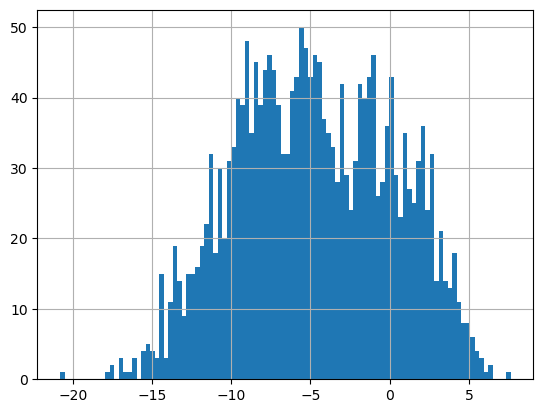

In [16]:
log_variance_of_variables_x.hist(bins=100)

In [9]:
df2 = Y_total.reset_index()[['pxl_row_transformed',"slice", 'pxl_column_transformed','Embryonic dSPN']]


In [6]:
df = pd.read_csv("predictions/prediction_X_all_estriatum_points_41.tsv", sep="\t")

df = df[['pxl_row_transformed', 'pxl_column_transformed', 'slice','hard_pred', 'soft_pred', 'soft_prob_NSC', 'soft_prob_NPC',
       'soft_prob_Striatal neuroblast', 'soft_prob_Embryonic iSPN',
       'soft_prob_Embryonic dSPN', 'soft_prob_Cortical neuron']]
uniques = pd.unique(df[['pxl_row_transformed', 'pxl_column_transformed', 'slice']].values.ravel())
len(uniques)

188

In [13]:
temp = pd.DataFrame({'litter': df["litter"].unique(),
     'slice': [220,230,240,250,215,225,235,245],
     })

df =  pd.merge(df, temp, on="litter")
df = df[['pxl_row_transformed', 'pxl_column_transformed', 'slice','hard_pred', 'soft_pred', 'soft_prob_NSC', 'soft_prob_NPC',
       'soft_prob_Striatal neuroblast', 'soft_prob_Embryonic iSPN',
       'soft_prob_Embryonic dSPN', 'soft_prob_Cortical neuron']]

In [15]:
uniques = pd.unique(df[['pxl_row_transformed', 'pxl_column_transformed', 'slice']].values.ravel())

len(uniques)

106

In [7]:
import plotly.express as px

# Create the 3D scatter plot using plotly.express
fig = px.scatter_3d(df, x="pxl_row_transformed", y='pxl_column_transformed', z='slice', color='hard_pred',opacity=0.6)

# Set labels and title
fig.update_layout(scene=dict(
   xaxis_title='X Label',
   yaxis_title='Y Label',
   zaxis_title='Z Label'
))
fig.update_layout(title='3D Scatter Plot')
fig.update_coloraxes(colorbar=dict(tickvals=list(np.linspace(0,1,11))))
# Display the plot
fig.update_layout(autosize=True) # remove height=800
fig.show(renderer="browser")

In [88]:
import plotly.graph_objects as go

Striatal_neuroblast = go.Scatter3d(mode="markers", name="Striatal neuroblast" , x=df["pxl_row_transformed"], y=df['pxl_column_transformed'], z=df['slice'], marker=dict(cmax=1, cmin=0, coloraxis = "coloraxis", colorscale='Viridis', color=df['soft_prob_Striatal neuroblast'],opacity=0.6 ))
NSC = go.Scatter3d(mode="markers", name="NSC", x=df["pxl_row_transformed"], y=df['pxl_column_transformed'], z=df['slice'],  marker=dict(cmax=1, cmin=0,  coloraxis = "coloraxis",color=df['soft_prob_NSC'],opacity=0.6 ))
NPC = go.Scatter3d(mode="markers", name="NPC", x=df["pxl_row_transformed"], y=df['pxl_column_transformed'], z=df['slice'],  marker=dict(cmax=1, cmin=0,  coloraxis = "coloraxis",color=df['soft_prob_NPC'],opacity=0.6 ))
data = [Striatal_neuroblast, NSC, NPC]

fig = go.Figure(data=data)

fig.update_layout(scene=dict(
   xaxis_title='X Label',
   yaxis_title='Y Label',
   zaxis_title='Z Label'
))

fig.update_layout(title='3D Scatter Plot')

# Display the plot
fig.update_layout(autosize=True) # remove height=800
fig.show(renderer="browser")

In [183]:
df2 = df
df2['Total_cell'] = df2[['soft_prob_NSC', 'soft_prob_NPC',
       'soft_prob_Striatal neuroblast', 'soft_prob_Embryonic iSPN',
       'soft_prob_Embryonic dSPN', 'soft_prob_Cortical neuron']].sum(axis=1)
cells = ['soft_prob_NSC', 'soft_prob_NPC',
       'soft_prob_Striatal neuroblast', 'soft_prob_Embryonic iSPN',
       'soft_prob_Embryonic dSPN', 'soft_prob_Cortical neuron',"Total_cell"]
for i in cells:
    df2[i] = (df2[i]/df2["Total_cell"]).round()
df2 = df2.drop("Total_cell", axis=1)
df2

,pxl_row_transformed,pxl_column_transformed,slice,hard_pred,soft_pred,soft_prob_NSC,soft_prob_NPC,soft_prob_Striatal neuroblast,soft_prob_Embryonic iSPN,soft_prob_Embryonic dSPN,soft_prob_Cortical neuron
0,184,124,220.0,Embryonic dSPN,Embryonic dSPN,0.0,0.0,0.0,0.0,1.0,0.0
1,195,130,230.0,Embryonic dSPN,Embryonic dSPN,0.0,0.0,0.0,0.0,1.0,0.0
2,146,109,240.0,Embryonic dSPN,Embryonic dSPN,0.0,0.0,0.0,0.0,1.0,0.0
3,152,113,250.0,Embryonic dSPN,Embryonic dSPN,0.0,0.0,0.0,0.0,1.0,0.0
4,170,139,215.0,NSC,NSC,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
510,129,117,NaN,Cortical neuron,Striatal neuroblast,0.0,0.0,1.0,0.0,0.0,0.0
511,150,122,NaN,NPC,Embryonic dSPN,0.0,0.0,0.0,0.0,1.0,0.0
512,174,133,NaN,NSC,NSC,1.0,0.0,0.0,0.0,0.0,0.0
513,159,135,NaN,NSC,Striatal neuroblast,0.0,0.0,1.0,0.0,0.0,0.0


In [222]:
uniques = pd.unique(df2[['pxl_row_transformed', 'pxl_column_transformed', 'slice']].values.ravel())

len(uniques)

107

In [55]:
df2

,pxl_row_transformed,slice,pxl_column_transformed,Embryonic dSPN
0,159.0,220,111,0.931386
1,152.0,220,111,0.902893
2,146.0,220,106,0.026058
3,144.0,220,112,0.891423
4,136.0,220,112,0.000000
...,...,...,...,...
571,140.0,245,106,0.861758
572,134.0,245,106,0.829782
573,129.0,245,107,0.804542
574,123.0,245,107,0.553925


In [42]:
import plotly.express as px

# Create the 3D scatter plot using plotly.express
fig = px.scatter_3d(df2, x="pxl_row_transformed", y='pxl_column_transformed', z='slice', color='Embryonic dSPN',opacity=0.6,size_max=5)

# Set labels and title
fig.update_layout(scene=dict(
   xaxis_title='X Label',
   yaxis_title='Y Label',
   zaxis_title='Z Label'
))
fig.update_layout(title='3D Scatter Plot')

# Display the plot
fig.update_layout(autosize=True) # remove height=800
fig.show(renderer="browser")

In [116]:
df2 = Y_total.reset_index()[['pxl_row_transformed',"slice", 'pxl_column_transformed', 'NPC', 'Embryonic dSPN', 'NSC',
       'Cortical neuron', 'Embryonic iSPN', 'Striatal neuroblast']]
df2['Total_cell'] = df2[['NPC', 'Embryonic dSPN', 'NSC',
       'Cortical neuron', 'Embryonic iSPN', 'Striatal neuroblast']].sum(axis=1)
cells = ['NPC', 'Embryonic dSPN', 'NSC',
       'Cortical neuron', 'Embryonic iSPN', 'Striatal neuroblast',"Total_cell"]
for i in cells:
    df2[i] = (df2[i]/df2["Total_cell"]).round()
df2 = df2.drop("Total_cell", axis=1)

In [118]:
df2

,pxl_row_transformed,slice,pxl_column_transformed,NPC,Embryonic dSPN,NSC,Cortical neuron,Embryonic iSPN,Striatal neuroblast
0,159.0,220,111,0.0,1.0,0.0,0.0,0.0,0.0
1,152.0,220,111,0.0,1.0,0.0,0.0,0.0,0.0
2,146.0,220,106,0.0,0.0,0.0,1.0,0.0,0.0
3,144.0,220,112,0.0,1.0,0.0,0.0,0.0,0.0
4,136.0,220,112,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
571,140.0,245,106,0.0,1.0,0.0,0.0,0.0,0.0
572,134.0,245,106,0.0,1.0,0.0,0.0,0.0,0.0
573,129.0,245,107,0.0,1.0,0.0,0.0,0.0,0.0
574,123.0,245,107,0.0,1.0,0.0,0.0,0.0,0.0


In [99]:
dfes[dfes["value"]!=0]

,x,y,z,value
42388620,185,167,140,1
42389640,185,170,140,1
42389980,185,171,140,1
42390320,185,172,140,1
42390321,185,172,141,1
...,...,...,...,...
66630246,291,128,106,1
66630586,291,129,106,1
66859066,292,128,106,1
66860087,292,131,107,1


In [97]:
estriat

IndexError: boolean index did not match indexed array along dimension 0; dimension is 552 but corresponding boolean dimension is 126308640

In [21]:
estri = sitk.ReadImage("../atlasVolume/estriat-Segment_15861-label.mhd")
est = sitk.GetArrayFromImage(estri)
estriat = est.transpose(2,1,0) 
idx = pd.MultiIndex.from_product([range(s) for s in estriat.shape], names=['x', 'y', 'z'])

dfes = pd.DataFrame({'value': estriat.flatten()}, index=idx).reset_index()

In [22]:
import plotly.express as px

# Create the 3D scatter plot using plotly.express
fig = px.scatter_3d(dfes[dfes["value"]!=0], x="x", y='y', z='z', color='value',opacity=0.1,size_max=5)

# Set labels and title
fig.update_layout(scene=dict(
   xaxis_title='X Label',
   yaxis_title='Y Label',
   zaxis_title='Z Label'
))
fig.update_layout(title='3D Scatter Plot')

# Display the plot
fig.update_layout(autosize=True) # remove height=800
fig.show(renderer="browser")

In [11]:
Striatal_NB = df[["pxl_row_transformed", "pxl_column_transformed", "slice", "soft_prob_Striatal neuroblast"]]
Striatal_NB.set_index(['pxl_row_transformed', 'pxl_column_transformed', "slice"], inplace=True)
# Create a SimpleITK image from the numpy array


In [38]:
%%time
Striatal_NB.query("pxl_row_transformed == 167 and pxl_column_transformed == 140 and slice == 140 ")

CPU times: total: 0 ns
Wall time: 4.99 ms


,,,soft_prob_Striatal neuroblast
pxl_row_transformed,pxl_column_transformed,slice,


In [13]:
Striatal_NB[(Striatal_NB["pxl_row_transformed"] == 167) & (Striatal_NB["pxl_column_transformed"] == 140) & (Striatal_NB["slice"] == 15)]["soft_prob_Striatal neuroblast"].empty

KeyError: 'pxl_row_transformed'

In [8]:
%%time
zero_array = np.zeros((340, 673, 552))
for i in range(340):
    for j in range(673):
        for t in range(20):
            value = df[(df["pxl_row_transformed"] == i) & (df["pxl_column_transformed"] == j) & (df["slice"] == t)]["soft_prob_Striatal neuroblast"]
            if not value.empty:
               zero_array[i,j,t] =  value.iloc[0]

image = sitk.GetImageFromArray(zero_array)

CPU times: total: 1min 46s
Wall time: 1min 48s


In [ ]:
image.ImageFileWriter("test.mhd")

In [36]:
Striatal_NB.query("pxl_row_transformed ==" + str(i) +" and pxl_column_transformed == " + str(j) +" and slice == " + str(t))["soft_prob_Striatal neuroblast"]

0

In [11]:
df

,pxl_row_transformed,pxl_column_transformed,slice,hard_pred,soft_pred,soft_prob_NSC,soft_prob_NPC,soft_prob_Striatal neuroblast,soft_prob_Embryonic iSPN,soft_prob_Embryonic dSPN,soft_prob_Cortical neuron
0,167,140,185,NPC,Striatal neuroblast,0.009552,0.391276,0.598546,0.000154,0.000004,4.682890e-04
1,170,140,185,NPC,Striatal neuroblast,0.006299,0.320752,0.672055,0.000186,0.000004,7.051070e-04
2,171,140,185,NPC,Striatal neuroblast,0.006319,0.272481,0.720112,0.000225,0.000006,8.574628e-04
3,172,140,185,NPC,Striatal neuroblast,0.006276,0.228286,0.764129,0.000270,0.000009,1.030812e-03
4,172,141,185,NPC,Striatal neuroblast,0.024072,0.207777,0.765973,0.000562,0.000039,1.577764e-03
...,...,...,...,...,...,...,...,...,...,...,...
94241,128,106,291,Embryonic dSPN,Embryonic dSPN,0.005926,0.000046,0.038038,0.000049,0.955941,2.195596e-09
94242,129,106,291,Embryonic dSPN,Embryonic dSPN,0.001720,0.000018,0.020035,0.000028,0.978200,8.972696e-10
94243,128,106,292,Embryonic dSPN,Embryonic dSPN,0.007372,0.000052,0.043556,0.000049,0.948972,1.818388e-09
94244,131,107,292,Embryonic dSPN,Embryonic dSPN,0.052074,0.000032,0.140330,0.000128,0.807436,4.414735e-09
